# STEP1. キーワードリストを埋め込み

In [10]:
import torch.nn.functional as F

from torch import Tensor
from transformers import AutoTokenizer, AutoModel

import numpy as np
import pandas as pd

In [11]:
li = pd.read_csv("list_sample1.csv", encoding="cp932", header=None).drop_duplicates()
li = li.sort_values(0).reset_index(drop=True)
li

,0
0,YouTube
1,アウトドアグッズ
2,アニメの一気見
3,カフェ
4,キャンプ用品
5,ゲーム実況
6,コーヒー豆
7,ラーメン食べ歩き
8,地元の隠れた名所探し
9,夜景スポット巡り


In [12]:
def average_pool(last_hidden_states: Tensor, attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

tokenizer = AutoTokenizer.from_pretrained('Z:\models\multilingual-e5-large')
model = AutoModel.from_pretrained('Z:\models\multilingual-e5-large').to("cuda:0")

In [13]:
keywords = li[0].values
input_texts = [f'query: {keyword}' for keyword in keywords]

batch_dict = tokenizer(input_texts, max_length=512, padding=True, truncation=True, return_tensors='pt').to("cuda:0")
outputs = model(**batch_dict)

embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
embeddings = F.normalize(embeddings, p=2, dim=1).cpu().detach().numpy()
embeddings.shape # n x 1024

(21, 1024)

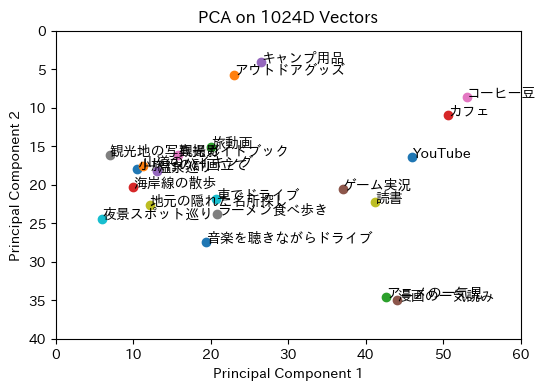

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import japanize_matplotlib

# PCAのインスタンスを作成し、2次元に次元削減します。
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

map_width = 60
map_height = 40

pca_result -= pca_result.min(axis=0)
pca_result /= pca_result.max(axis=0)
pca_result[:, 0] *= (map_width * 0.8 - 1)
pca_result[:, 1] *= (map_height * 0.8 - 1)
pca_result[:, 0] += map_width * 0.1
pca_result[:, 1] += map_height * 0.1

# 次元削減した結果をプロットします。
plt.figure(figsize=(map_width // 10, map_height // 10))
for i, label in enumerate(keywords):
    plt.scatter(pca_result[i, 0], pca_result[i, 1])
    plt.text(pca_result[i, 0], pca_result[i, 1], label)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA on 1024D Vectors')
plt.xlim(0, map_width)
plt.ylim(0, map_height)
plt.gca().invert_yaxis()
plt.show()

In [15]:
df_embeddings = pd.concat([pd.DataFrame(li[0].values), pd.DataFrame(pca_result)], axis=1)
df_embeddings.columns = ["keywords", "0", "1"]
df_embeddings

,keywords,0,1
0,YouTube,46.001278,16.453854
1,アウトドアグッズ,22.965628,5.722549
2,アニメの一気見,42.598152,34.595383
3,カフェ,50.604305,10.952946
4,キャンプ用品,26.522942,4.000000
5,ゲーム実況,37.080246,20.588850
6,コーヒー豆,53.000000,8.668265
7,ラーメン食べ歩き,20.747826,23.846554
8,地元の隠れた名所探し,12.126865,22.625069
9,夜景スポット巡り,6.000000,24.396473


In [16]:
df_embeddings.to_csv("embeddings.csv")